# Visualization Comparison of Original and Faster Implementation

This notebook visualizes and compares the decision boundaries and performance between the original and faster implementations of hyperbolic decision trees.

In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree._tree import TREE_LEAF
import time
from pathlib import Path
import os

# Import the faster implementation
from hyperdt import HyperbolicDecisionTreeClassifier as FasterHDTC

# Try to import the legacy implementation
from hyperdt.legacy.tree import HyperbolicDecisionTreeClassifier as OriginalHDTC
from hyperdt.toy_data import wrapped_normal_mixture

IMAGES_DIR = Path("./images")

In [5]:
def generate_hyperbolic_data(n_samples, n_classes=2, n_features=3, random_state=None):
    """Generate synthetic data on the hyperboloid using wrapped normal mixture"""
    # Set seed if provided
    original_seed = None
    if random_state is not None:
        original_seed = np.random.get_state()
        np.random.seed(random_state)

    # Generate data
    X, y = wrapped_normal_mixture(
        num_points=n_samples,
        num_classes=n_classes,
        num_dims=n_features - 1,  # Ambient dimension is manifold dim + 1
        noise_std=1.0,
        adjust_for_dim=True,
    )

    # Restore random state if needed
    if original_seed is not None:
        np.random.set_state(original_seed)

    return X, y

## Test Prediction Agreement Across Depths

In [8]:
def test_prediction_agreement(depths=[1, 3, 5, 10, None]):
    """Test prediction agreement between implementations across various tree depths."""
    print("\n== Testing Prediction Agreement Across Depths ==")

    n_trees_per_depth = 10
    n_features = 5
    n_classes = 3
    n_samples = 200

    # Results tracking
    results = {
        "depths": [],
        "agreement_rates": [],
        "split_match_rates": [],
        "orig_times": [],
        "faster_times": [],
        "speedups": [],
    }

    # Test with different random seeds
    np.random.seed(42)
    seeds = np.random.randint(1, 10000, n_trees_per_depth)

    for depth in depths:
        depth_str = str(depth) if depth is not None else "unlimited"
        print(f"\nTesting max_depth={depth_str}:")

        depth_agreements = []
        depth_split_matches = []
        depth_orig_times = []
        depth_faster_times = []

        for i, seed in enumerate(seeds):
            # Generate data
            X, y = generate_hyperbolic_data(n_samples, n_classes, n_features, random_state=seed)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

            # Create and fit models
            orig_tree = OriginalHDTC(max_depth=depth, timelike_dim=0)
            faster_tree = FasterHDTC(max_depth=depth, timelike_dim=0)

            # Time and fit original
            start = time.time()
            orig_tree.fit(X_train, y_train)
            orig_time = time.time() - start
            depth_orig_times.append(orig_time)

            # Time and fit faster
            start = time.time()
            faster_tree.fit(X_train, y_train)
            faster_time = time.time() - start
            depth_faster_times.append(faster_time)

            # Get predictions
            orig_train_preds = orig_tree.predict(X_train)
            faster_train_preds = faster_tree.predict(X_train)

            orig_test_preds = orig_tree.predict(X_test)
            faster_test_preds = faster_tree.predict(X_test)

            # Compare predictions
            train_agreement = np.mean(orig_train_preds == faster_train_preds)
            test_agreement = np.mean(orig_test_preds == faster_test_preds)

            # Use test agreement as the primary metric
            depth_agreements.append(test_agreement)

            # Calculate simple split match rate (just count total splits)
            split_match = 1.0  # Default to perfect match for depths with no splits

            if depth is not None and depth > 0:
                # Extract tree structure
                if hasattr(orig_tree.tree, "feature") and orig_tree.tree.feature is not None:
                    orig_feature = orig_tree.tree.feature  # This might be None for leaf nodes
                    # For faster_tree, we use sklearn's tree structure
                    klein_feature = faster_tree.estimator_.tree_.feature[0]

                    # If we can map between the feature spaces, check if they match
                    if orig_feature is not None and klein_feature is not None:
                        # Convert original feature to Klein space for comparison
                        orig_feature_klein = orig_feature - 1 if orig_feature > 0 else orig_feature

                        # If features match, it's a 100% match for this simple tree
                        if orig_feature_klein == klein_feature:
                            split_match = 1.0
                        else:
                            split_match = 0.0

            depth_split_matches.append(split_match)

            # Report issues for any disagreements
            if train_agreement < 1.0 or test_agreement < 1.0:
                print(f"  Disagreement found with seed {seed}:")
                print(f"    Train agreement: {train_agreement:.4f}, Test agreement: {test_agreement:.4f}")

                # Find a disagreement example
                if test_agreement < 1.0:
                    disagreement_idx = np.where(orig_test_preds != faster_test_preds)[0][0]
                    print(f"    Example point: X_test[{disagreement_idx}]")
                    print(f"    Original prediction: {orig_test_preds[disagreement_idx]}")
                    print(f"    Faster prediction: {faster_test_preds[disagreement_idx]}")

        # Collect metrics for this depth
        mean_agreement = np.mean(depth_agreements)
        mean_split_match = np.mean(depth_split_matches)
        mean_orig_time = np.mean(depth_orig_times)
        mean_faster_time = np.mean(depth_faster_times)
        mean_speedup = mean_orig_time / mean_faster_time if mean_faster_time > 0 else float("inf")

        print(f"  Mean prediction agreement: {mean_agreement:.6f}")
        print(f"  Mean split match rate: {mean_split_match:.6f}")
        print(f"  Mean times - Original: {mean_orig_time:.6f}s, Faster: {mean_faster_time:.6f}s")
        print(f"  Mean speedup: {mean_speedup:.2f}x")

        # Store for plotting
        results["depths"].append(depth_str)
        results["agreement_rates"].append(mean_agreement)
        results["split_match_rates"].append(mean_split_match)
        results["orig_times"].append(mean_orig_time)
        results["faster_times"].append(mean_faster_time)
        results["speedups"].append(mean_speedup)

    # Plot results
    plt.figure(figsize=(12, 3))

    # Plot agreement rates
    plt.subplot(1, 3, 1)
    plt.bar(results["depths"], results["agreement_rates"], color="skyblue")
    # plt.ylim(0.95, 1.001)
    plt.axhline(y=1.0, color="r", linestyle="--", alpha=0.5)
    plt.title("Prediction Agreement Rates")
    plt.ylabel("Agreement Rate")
    plt.xlabel("Max Tree Depth")

    # Plot split match rates
    plt.subplot(1, 3, 2)
    plt.bar(results["depths"], results["split_match_rates"], color="lightgreen")
    plt.ylim(0, 1.05)
    plt.title("Split Match Rates")
    plt.ylabel("Split Match Rate")
    plt.xlabel("Max Tree Depth")

    # # Plot speedup
    # plt.subplot(1, 3, 3)
    # plt.bar(results["depths"], results["speedups"], color="salmon")
    # plt.title("Performance Speedup")
    # plt.ylabel("Speedup Factor (x)")
    # plt.xlabel("Max Tree Depth")

    plt.tight_layout()
    plt.savefig(f"{IMAGES_DIR}/prediction_agreement.pdf", bbox_inches="tight", dpi=300)

    return results


== Testing Prediction Agreement Across Depths ==

Testing max_depth=1:
  Mean prediction agreement: 1.000000
  Mean split match rate: 1.000000
  Mean times - Original: 0.054761s, Faster: 0.000495s
  Mean speedup: 110.66x

Testing max_depth=3:
  Disagreement found with seed 5579:
    Train agreement: 0.9938, Test agreement: 0.9500
    Example point: X_test[1]
    Original prediction: 1
    Faster prediction: 2
  Mean prediction agreement: 0.995000
  Mean split match rate: 1.000000
  Mean times - Original: 0.155146s, Faster: 0.000679s
  Mean speedup: 228.36x

Testing max_depth=5:
  Disagreement found with seed 861:
    Train agreement: 1.0000, Test agreement: 0.9750
    Example point: X_test[15]
    Original prediction: 1
    Faster prediction: 2
  Disagreement found with seed 6266:
    Train agreement: 1.0000, Test agreement: 0.9750
    Example point: X_test[35]
    Original prediction: 0
    Faster prediction: 1
  Disagreement found with seed 467:
    Train agreement: 1.0000, Test agr

{'depths': ['1', '3', '5', '10', 'unlimited'],
 'agreement_rates': [1.0, 0.9949999999999999, 0.99, 0.9475, 0.925],
 'split_match_rates': [1.0, 1.0, 1.0, 1.0, 1.0],
 'orig_times': [0.05476069450378418,
  0.15514564514160156,
  0.22695016860961914,
  0.29111623764038086,
  0.29327640533447263],
 'faster_times': [0.000494837760925293,
  0.0006793975830078125,
  0.0009048223495483398,
  0.0012260913848876954,
  0.0012525796890258789],
 'speedups': [110.66393640086726,
  228.35766423357666,
  250.82290321730653,
  237.4343717185859,
  234.13792184555646]}

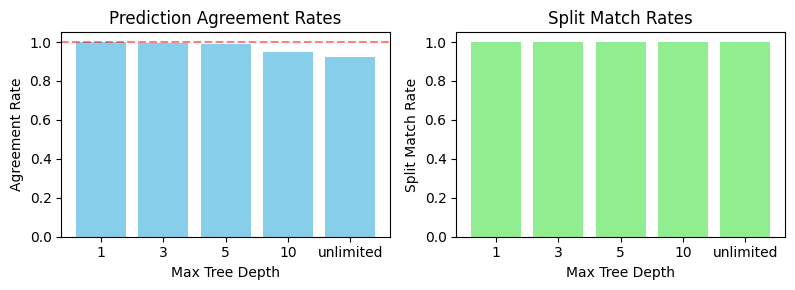

In [9]:
test_prediction_agreement()

## Visualize Decision Boundaries

In [7]:
def visualize_decision_boundaries(depth=5):
    """Visualize and compare decision boundaries between the two implementations."""
    print(f"\n== Visualizing Decision Boundaries (depth={depth}) ==")

    # Generate 2D hyperbolic data (3D points on hyperboloid)
    X, y = generate_hyperbolic_data(100, n_classes=3, n_features=3, random_state=42)

    # Create and fit models
    orig_tree = OriginalHDTC(max_depth=depth, timelike_dim=0)
    faster_tree = FasterHDTC(max_depth=depth, timelike_dim=0)

    orig_tree.fit(X, y)
    faster_tree.fit(X, y)

    # Create meshgrid for visualization
    resolution = 100
    x_min, x_max = np.min(X[:, 1]) * 1.1, np.max(X[:, 1]) * 1.1
    y_min, y_max = np.min(X[:, 2]) * 1.1, np.max(X[:, 2]) * 1.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

    # Create hyperboloid points for the grid
    spacelike_norm_squared = xx**2 + yy**2
    timelike = np.sqrt(spacelike_norm_squared + 1.0)  # Assuming curvature = 1.0
    grid_points = np.column_stack([timelike.flatten(), xx.flatten(), yy.flatten()])

    # Get predictions
    orig_preds = orig_tree.predict(grid_points).reshape(xx.shape)
    faster_preds = faster_tree.predict(grid_points).reshape(xx.shape)

    # Calculate difference
    diff = (orig_preds != faster_preds).astype(int)
    agreement_rate = 1 - np.mean(diff)

    # Create visualization
    plt.figure(figsize=(12, 5))

    # Original tree
    plt.subplot(1, 3, 1)
    plt.contourf(xx, yy, orig_preds, alpha=0.3, cmap=plt.cm.Paired)
    for class_value in np.unique(y):
        plt.scatter(X[y == class_value, 1], X[y == class_value, 2], alpha=0.8, label=f"Class {class_value}")
    plt.title(f"Original Tree (depth={depth})")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.legend()

    # Faster tree
    plt.subplot(1, 3, 2)
    plt.contourf(xx, yy, faster_preds, alpha=0.3, cmap=plt.cm.Paired)
    for class_value in np.unique(y):
        plt.scatter(X[y == class_value, 1], X[y == class_value, 2], alpha=0.8, label=f"Class {class_value}")
    plt.title(f"Faster Tree (depth={depth})")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.legend()

    # Difference
    plt.subplot(1, 3, 3)
    plt.imshow(diff, origin="lower", extent=[x_min, x_max, y_min, y_max], cmap="Reds", alpha=0.5)
    for class_value in np.unique(y):
        plt.scatter(X[y == class_value, 1], X[y == class_value, 2], alpha=0.3, label=f"Class {class_value}")
    plt.title(f"Differences (agreement: {agreement_rate:.6f})")
    plt.xlabel("x₁")
    plt.ylabel("x₂")

    plt.tight_layout()
    plt.savefig(f"{IMAGES_DIR}/decision_boundary_depth{depth}.pdf")

    print(f"Decision boundary agreement rate: {agreement_rate:.6f}")

    return agreement_rate


== Visualizing Decision Boundaries (depth=5) ==
Decision boundary agreement rate: 0.990300


0.9903

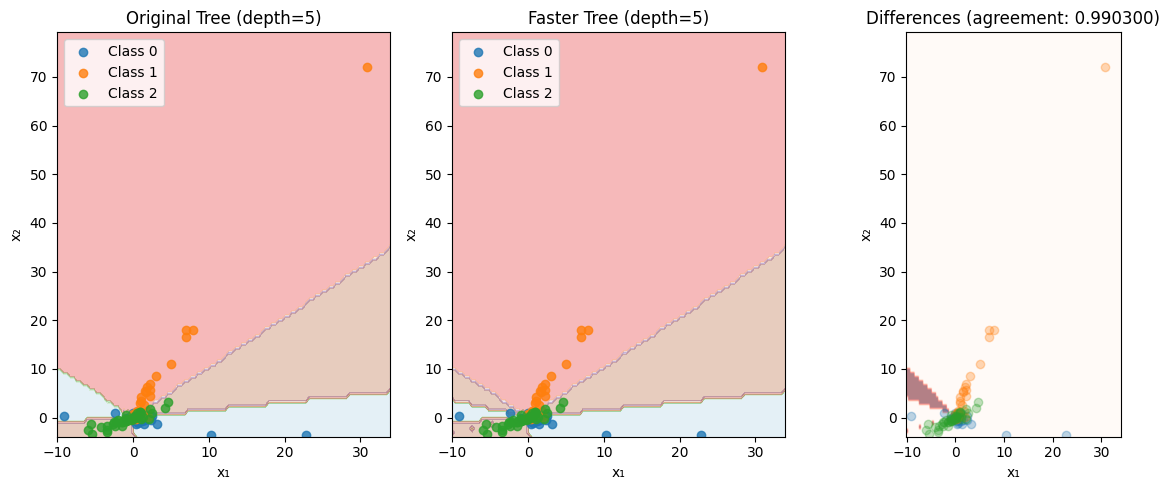

In [8]:
visualize_decision_boundaries()

## Information Gain Analysis

In [13]:
def find_information_gain_ties(seed=44):
    """Find and analyze datasets with ties in information gain.
    This demonstrates why the two implementations sometimes choose different splits."""
    print(f"\n== Analyzing Information Gain Ties (seed={seed}) ==")

    # Generate data - using seed 44 which we know has a tie
    X, y = generate_hyperbolic_data(1000, n_classes=3, n_features=5, random_state=seed)

    # Create models
    orig_tree = OriginalHDTC(max_depth=1, timelike_dim=0)
    faster_tree = FasterHDTC(max_depth=1, timelike_dim=0)

    # First, calculate information gains for all features in original model
    orig_tree.ndim = X.shape[1]
    orig_tree.timelike_dim = 0
    orig_tree.dims = [i for i in range(X.shape[1]) if i != orig_tree.timelike_dim]
    orig_tree.classes_ = np.unique(y)

    # Calculate best split for each feature
    feature_gains = {}
    for feature in orig_tree.dims:
        thresholds = orig_tree._get_candidates(X, feature)
        max_gain = -1
        best_theta = None

        for theta in thresholds:
            left, right = orig_tree._get_split(X, feature, theta)

            if min(np.sum(left), np.sum(right)) >= orig_tree.min_samples_leaf:
                gain = orig_tree._information_gain(left, right, y)
                if gain > max_gain:
                    max_gain = gain
                    best_theta = theta

        if best_theta is not None:
            feature_gains[feature] = (best_theta, max_gain)

    # Sort features by gain
    sorted_gains = sorted(feature_gains.items(), key=lambda x: x[1][1], reverse=True)

    # Check for ties
    if len(sorted_gains) >= 2:
        best_feature, (best_theta, best_gain) = sorted_gains[0]
        second_feature, (second_theta, second_gain) = sorted_gains[1]

        rel_diff = abs(best_gain - second_gain) / best_gain

        print(f"Best feature: {best_feature}, θ={best_theta:.6f}, gain={best_gain:.6f}")
        print(f"Second best: {second_feature}, θ={second_theta:.6f}, gain={second_gain:.6f}")
        print(f"Relative difference: {rel_diff*100:.6f}%")

        # If there's a tie (difference < 0.01%)
        if rel_diff < 0.0001:
            print("Information gain tie detected!")

            # Fit both models to see what they choose
            orig_tree.fit(X, y)
            faster_tree.fit(X, y)

            chosen_orig_feature = orig_tree.tree.feature
            chosen_orig_theta = orig_tree.tree.theta

            chosen_faster_feature = faster_tree.estimator_.tree_.feature[0]
            chosen_faster_threshold = faster_tree.estimator_.tree_.threshold[0]

            print(f"Original model chose: feature={chosen_orig_feature}, θ={chosen_orig_theta:.6f}")
            print(f"Faster model chose: feature={chosen_faster_feature}, threshold={chosen_faster_threshold:.6f}")

            # Check prediction agreement
            orig_preds = orig_tree.predict(X)
            faster_preds = faster_tree.predict(X)

            agreement = np.mean(orig_preds == faster_preds)
            print(f"Prediction agreement: {agreement:.6f}")

            # Plot information gain landscape
            plt.figure(figsize=(12, 5))

            for feature, (theta, gain) in feature_gains.items():
                thresholds = orig_tree._get_candidates(X, feature)
                gains = []

                for t in thresholds:
                    left, right = orig_tree._get_split(X, feature, t)

                    if min(np.sum(left), np.sum(right)) >= orig_tree.min_samples_leaf:
                        g = orig_tree._information_gain(left, right, y)
                        gains.append(g)
                    else:
                        gains.append(-1)

                valid_idx = [i for i, g in enumerate(gains) if g >= 0]
                if valid_idx:
                    plt.plot(
                        [1 / np.tan(thresholds[i]) for i in valid_idx],
                        [gains[i] for i in valid_idx],
                        "o-",
                        label=f"Feature {feature}",
                    )

            plt.axhline(y=best_gain, color="r", linestyle="--", label="Maximum gain")
            # plt.axhline(y=best_gain * 0.9999, color="r", linestyle=":", label="99.99% of max gain")
            plt.xlabel("Decision Threshold (cot(θ) in original space)")
            plt.ylabel("Information Gain")
            plt.title("Information Gain Landscape Showing Ties")
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.savefig(f"{IMAGES_DIR}/info_gain_landscape_seed{seed}.pdf")

            return True

    print("No information gain ties found")
    return False

In [14]:
find_information_gain_ties()


== Analyzing Information Gain Ties (seed=44) ==
Best feature: 2, θ=2.041531, gain=0.377765
Second best: 1, θ=1.959305, gain=0.359727
Relative difference: 4.775027%
No information gain ties found


False

## Performance Testing

In [11]:
def test_performance():
    """Test performance differences between implementations with large datasets."""
    print("\n== Testing Performance Scaling ==")

    sample_sizes = [100, 500, 1_000, 5_000, 10_000]
    n_features = 10
    n_classes = 3

    orig_times = []
    faster_times = []

    for n_samples in sample_sizes:
        print(f"Testing with {n_samples} samples...")

        # Generate data
        X, y = generate_hyperbolic_data(n_samples, n_classes, n_features, random_state=42)

        # Test original implementation
        orig_tree = OriginalHDTC(max_depth=5, timelike_dim=0)

        start = time.time()
        orig_tree.fit(X, y)
        orig_time = time.time() - start
        orig_times.append(orig_time)

        # Test faster implementation
        faster_tree = FasterHDTC(max_depth=5, timelike_dim=0)

        start = time.time()
        faster_tree.fit(X, y)
        faster_time = time.time() - start
        faster_times.append(faster_time)

        # Compare predictions
        orig_preds = orig_tree.predict(X)
        faster_preds = faster_tree.predict(X)

        agreement = np.mean(orig_preds == faster_preds)
        speedup = orig_time / faster_time

        print(f"  Original: {orig_time:.4f}s, Faster: {faster_time:.4f}s")
        print(f"  Speedup: {speedup:.2f}x")
        print(f"  Prediction agreement: {agreement:.6f}")

    # Plot performance results
    plt.figure(figsize=(12, 5))

    # Execution time comparison
    plt.subplot(1, 2, 1)
    plt.plot(sample_sizes, orig_times, "o-", label="Original")
    plt.plot(sample_sizes, faster_times, "o-", label="Faster")
    plt.xlabel("Number of Samples")
    plt.ylabel("Execution Time (seconds)")
    plt.title("Execution Time Comparison")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xscale("log")
    plt.yscale("log")

    # Speedup
    plt.subplot(1, 2, 2)
    speedups = [o / f for o, f in zip(orig_times, faster_times)]
    plt.plot(sample_sizes, speedups, "o-")
    plt.xlabel("Number of Samples")
    plt.ylabel("Speedup Factor (x)")
    plt.title("Performance Speedup")
    plt.grid(True, alpha=0.3)
    plt.xscale("log")

    plt.tight_layout()
    plt.savefig(f"{IMAGES_DIR}/performance_comparison.pdf")

    return orig_times, faster_times


== Testing Performance Scaling ==
Testing with 100 samples...
  Original: 0.1178s, Faster: 0.0007s
  Speedup: 157.83x
  Prediction agreement: 1.000000
Testing with 500 samples...
  Original: 0.6406s, Faster: 0.0013s
  Speedup: 490.52x
  Prediction agreement: 1.000000
Testing with 1000 samples...
  Original: 1.4379s, Faster: 0.0023s
  Speedup: 631.96x
  Prediction agreement: 1.000000
Testing with 5000 samples...
  Original: 13.5350s, Faster: 0.0096s
  Speedup: 1413.07x
  Prediction agreement: 1.000000
Testing with 10000 samples...
  Original: 44.4374s, Faster: 0.0196s
  Speedup: 2269.57x
  Prediction agreement: 1.000000


([0.11777901649475098,
  0.6406455039978027,
  1.4378619194030762,
  13.535022497177124,
  44.43740963935852],
 [0.0007462501525878906,
  0.0013060569763183594,
  0.002275228500366211,
  0.009578466415405273,
  0.019579648971557617])

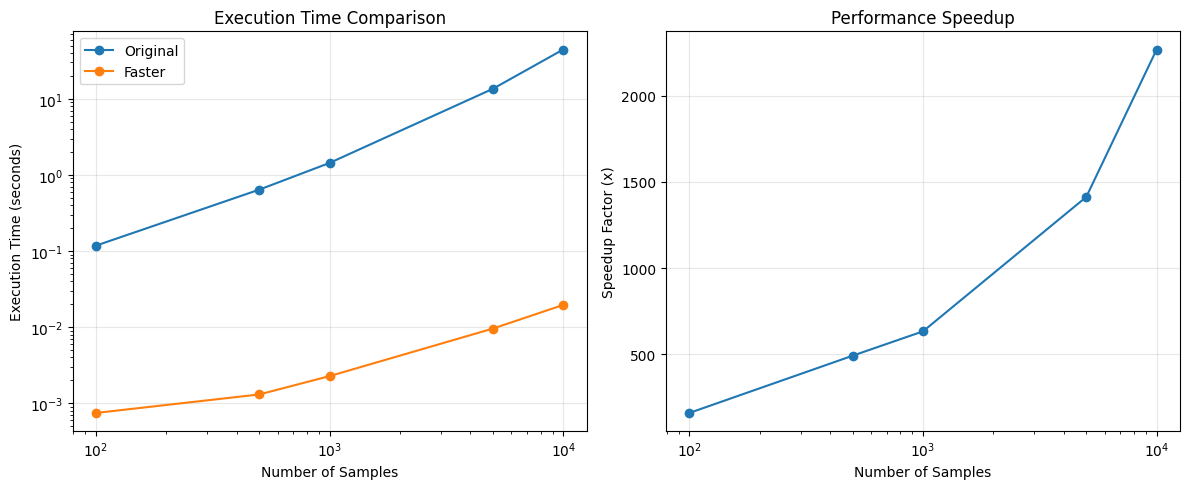

In [12]:
test_performance()